# CTC

- https://distill.pub/2017/ctc/
- http://people.idsia.ch/~juergen/tpami_2008.pdf

In [95]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Activation, Bidirectional, Conv2D, Dropout, Flatten, SimpleRNN, MaxPooling2D, Input, Dense, Lambda, TimeDistributed, Reshape, CuDNNLSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import SGD, RMSprop
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import TerminateOnNaN

import sys
sys.path.append('..')
from text_recognizer.datasets.emnist_lines import EmnistLinesDataset
from text_recognizer.models.line_rnn import LineLstm

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
dataset = EmnistLinesDataset(max_overlap=0.4)
dataset.load_or_generate_data()

EmnistLinesDataset loading data from HDF5...


In [44]:
class DatasetSequence(Sequence):
    def __init__(self, x, y, batch_size, output_sequence_length):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.output_sequence_length = output_sequence_length
    
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = np.take(self.x, range(idx * self.batch_size, (idx + 1) * self.batch_size), axis=0, mode='clip')
        batch_y = np.take(self.y, range(idx * self.batch_size, (idx + 1) * self.batch_size), axis=0, mode='clip')
        
#         batch_y = np.dstack((
#             batch_y,
#             np.zeros((batch_y.shape[0], batch_y.shape[1]))
#         ))
        
        batch_inputs = {
            'image': batch_x,
            'y_true': np.argmax(batch_y, -1),
            'input_length': np.ones((self.batch_size, 1)) * self.output_sequence_length,
            'label_length': np.array([np.where(batch_y[ind, :, -1] == 1)[0][0] for ind in range(self.batch_size)])
        }
#         batch_outputs = {
#             'categorical_crossentropy_loss_output': batch_y,
#             'ctc_loss_output': batch_y,
#             'acc_output': np.argmax(batch_y, -1)
#         }
        return batch_inputs, batch_y

In [202]:
## ADDING EDITDISTANCE

model = LineLstm()

def lenet(image_height: int, image_width: int) -> Model:
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(image_height, image_width, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    return model


class DatasetSequence(Sequence):
    def __init__(self, x, y, batch_size, output_sequence_length):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.output_sequence_length = output_sequence_length
    
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = np.take(self.x, range(idx * self.batch_size, (idx + 1) * self.batch_size), axis=0, mode='clip')
        batch_y = np.take(self.y, range(idx * self.batch_size, (idx + 1) * self.batch_size), axis=0, mode='clip')
        y_true = np.argmax(batch_y, -1)
        batch_inputs = {
            'image': batch_x,
            'y_true': y_true,
            'input_length': np.ones((self.batch_size, 1)) * self.output_sequence_length,
            'label_length': np.array([np.where(batch_y[ind, :, -1] == 1)[0][0] for ind in range(self.batch_size)])
        }
        batch_outputs = {
            'ctc_loss': np.zeros(batch_y.shape[0]),  # dummy
            'ctc_decoded': y_true
        }
        return batch_inputs, batch_outputs


from tensorflow.python.ops import ctc_ops

def ctc_decode(y_pred, input_length):
    """
    Cut down from https://github.com/keras-team/keras/blob/master/keras/backend/tensorflow_backend.py#L4170
    
    Decodes the output of a softmax.
    Uses greedy (best path) search.

    # Arguments
        y_pred: tensor `(samples, time_steps, num_categories)`
            containing the prediction, or output of the softmax.
        input_length: tensor `(samples, )` containing the sequence length for
            each batch item in `y_pred`.

    # Returns
        List: list of one element that contains the decoded sequence.
    """
    y_pred = tf.log(tf.transpose(y_pred, perm=[1, 0, 2]) + K.epsilon())
    input_length = tf.to_int32((tf.squeeze(input_length, axis=-1)))
    
    (decoded, _) = ctc_ops.ctc_greedy_decoder(inputs=y_pred, sequence_length=input_length)
    
    st = decoded[0]
    decoded_dense = tf.sparse_to_dense(st.indices, st.dense_shape, st.values, default_value=-1)
    
    # Unfortunately, decoded_dense will be of different number of columns, depending on the decodings.
    # We need to get it all in one standard shape, so let's pad if necessary.
    max_length = 32 + 2  # giving 2 extra characters for leeway
    cols = tf.shape(decoded_dense)[-1]
    def f1(): return tf.pad(decoded_dense, [[0, 0], [0, max_length - cols]], constant_values=-1)
    def f2(): return decoded_dense
    return tf.cond(tf.less(cols, max_length), f1, f2)


def create_sliding_window_rnn_model(input_shape, max_length, num_classes, window_width, window_stride):
    def slide_window(image, window_width=window_width, window_stride=window_stride):
        kernel = [1, 1, window_width, 1]
        strides = [1, 1, window_stride, 1]
        patches = tf.extract_image_patches(image, kernel, strides, [1, 1, 1, 1], 'SAME')
        patches = tf.transpose(patches, (0, 2, 1, 3))
        patches = tf.expand_dims(patches, -1)
        return patches
    
    image_height, image_width = input_shape    
    image_input = Input(shape=input_shape, name='image')
    y_true = Input(shape=(max_length,), name='y_true')
    input_length = Input(shape=(1,), name='input_length')
    label_length = Input(shape=(1,), name='label_length')
    
    image_reshaped = Reshape((image_height, image_width, 1))(image_input)
    image_patches = Lambda(slide_window)(image_reshaped)  # (num_windows, image_height, window_width, 1)
    convnet = lenet(image_height, window_width)
    convnet_outputs = TimeDistributed(convnet)(image_patches)  # (num_windows, 128)
    
    rnn_output = CuDNNLSTM(128, return_sequences=True)(convnet_outputs) # (sequence_length, 128)
    softmaxed_outputs = TimeDistributed(Dense(num_classes, activation='softmax'), name='softmax')(rnn_output) # (sequence_length, 128)
    
    ctc_loss_output = Lambda(
        lambda x: K.ctc_batch_cost(x[0], x[1], x[2], x[3]),
        name='ctc_loss'
    )([y_true, softmaxed_outputs, input_length, label_length])
    
    ctc_decoded_output = Lambda(
        lambda x: ctc_decode(x[0], x[1]),
        name='ctc_decoded'
    )([softmaxed_outputs, input_length])
    
    model = Model(inputs=[image_input, y_true, input_length, label_length], outputs=[ctc_loss_output, ctc_decoded_output])
    model.summary()
    return model


dataset_sequence = DatasetSequence(
    dataset.x_train,
    dataset.y_train,
    batch_size=16,
    output_sequence_length=32 * 2
)


keras_model = create_sliding_window_rnn_model(
    model.input_shape,
    model.max_length,
    model.num_classes,
    28 // 2,
    28 // 2
)


keras_model.compile(
    'rmsprop',
    loss={'ctc_loss': lambda yt, yp: yp}
)

history = keras_model.fit_generator(dataset_sequence, epochs=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 28, 896)      0                                            
__________________________________________________________________________________________________
reshape_71 (Reshape)            (None, 28, 896, 1)   0           image[0][0]                      
__________________________________________________________________________________________________
lambda_71 (Lambda)              (None, 64, 28, 14, 1 0           reshape_71[0][0]                 
__________________________________________________________________________________________________
time_distributed_62 (TimeDistri (None, 64, 128)      510464      lambda_71[0][0]                  
__________________________________________________________________________________________________
cu_dnnlstm

In [204]:
decoding_model = Model(inputs=keras_model.input, outputs=keras_model.get_layer('ctc_decoded').output)
preds = decoding_model.predict_generator(dataset_sequence)

In [224]:
pred_strings = [''.join(dataset.mapping.get(label, '') for label in pred).strip() for pred in preds]
true_strings = [''.join(dataset.mapping.get(label, '') for label in true).strip() for true in y_true]
char_accuracies = [
    1 - editdistance.eval(true_string, pred_string) / len(pred_string)
    for true_string, pred_string in zip(pred_strings, true_strings)
]
print(np.mean(char_accuracies))

0.7030521443293611


(1, 64, 65)
carry big sticks over laos


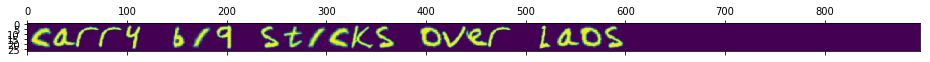

In [47]:
softmax_output_fn = K.function(
    [keras_model.get_layer('image').input, K.learning_phase()],
    [keras_model.get_layer('softmax').output]
)
input_image = np.expand_dims(dataset.x_test[0], 0)
softmax_output = softmax_output_fn([input_image, 0])[0]
print(softmax_output.shape)
pred_raw = K.eval(K.ctc_decode(softmax_output, np.array([64]))[0][0])
print(

import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(dataset.x_test[0])

In [74]:
neg_sum_logit = K.eval(K.ctc_decode(softmax_output, np.array([64]))[1])[0][0]
np.exp(neg_sum_logit) / (1 + np.exp(neg_sum_logit))

0.9470386578159365

In [94]:
decoded, log_prob = K.ctc_decode(softmax_output, np.array([64]))
pred_raw = K.eval(decoded[0])[0]
pred = ''.join(dataset.mapping[label] for label in pred_raw).strip()
conf = K.eval(K.softmax(log_prob))[0][0]
print(pred, conf)

carry big sticks over laos 1.0
